In [ ]:
!pip install torch_summary

In [11]:
import torch 
from torchvision import models
import pandas as pd
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import glob
import os
import cv2
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms
from torchsummary import summary
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [1]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6049, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 6049 (delta 3), reused 7 (delta 2), pack-reused 6038
Receiving objects: 100% (6049/6049), 329.53 MiB | 11.15 MiB/s, done.
Resolving deltas: 100% (156/156), done.


In [21]:
root_dir = '/kaggle/input/p1-facial-keypoints/P1_Facial_Keypoints/data/training'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('/kaggle/input/p1-facial-keypoints/P1_Facial_Keypoints/data/training_frames_keypoints.csv')

In [22]:
data.head(3)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0


In [23]:
doc = data.iloc[0]

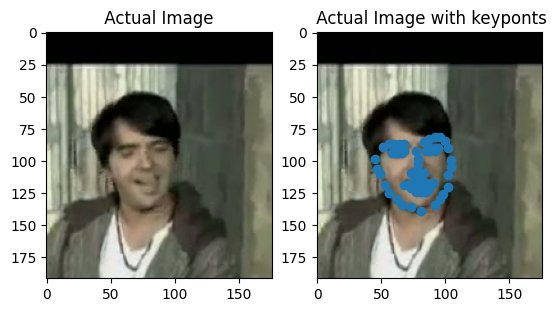

In [24]:
img_arr = cv2.imread(os.path.join(root_dir, 'Luis_Fonsi_21.jpg'))
img_arr = img_arr[:,:,::-1]
x_points = data.iloc[0][1:][::2]
y_points = data.iloc[0][2:][::2]
plt.subplot(121)
plt.imshow(img_arr)
plt.title(" Actual Image ")
plt.subplot(122)
plt.imshow(img_arr)
plt.scatter(list(x_points), list(y_points))
plt.title(" Actual Image with keyponts")
plt.show()

In [25]:
class FaceDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225])
        self.df = df

    def __getitem__(self, ix):
        doc = self.df.iloc[ix]
        image_name = doc[0]
        image_path = os.path.join(root_dir,image_name)  
        img_arr = cv2.imread(image_path)
        x_axis_points = doc[1:][::2]
        y_axis_points = doc[2:][::2]
        x_axis_points = list(x_axis_points/img_arr.shape[1])                                     
        y_axis_points = list(y_axis_points/img_arr.shape[0])                                    

        points = x_axis_points + y_axis_points  

        img_arr = img_arr/255.0                                                                 
        img = self.preprocess_img(img_arr)

        return img.to(device), torch.tensor(points).to(device)

    def __len__(self):
        return self.df.shape[0]


    def preprocess_img(self, img):
        img = cv2.resize(img, (224,224)) 
        img = torch.tensor(img).permute(2,0,1) 
        img = self.normalize(img).float()
        return img

    def load_img(self, ix):
        doc = self.df.iloc[ix]
        img_name = doc[0]
        img = cv2.imread(os.path.join(root_dir, img_name))
        return img

In [26]:
train_df, test_df = train_test_split(data, test_size=0.2)

In [27]:
train_dataset = FaceDataset(train_df)
test_dataset = FaceDataset(test_df)

In [28]:
train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=25, shuffle=True)

In [16]:
model = models.vgg16(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:16<00:00, 33.4MB/s] 


In [29]:
for param in model.parameters():
    param.requires_grad = False

In [30]:
from torch.nn.modules.activation import Sigmoid
from torch.nn.modules.pooling import AdaptiveAvgPool2d

pool_layer = nn.Sequential(
     nn.Conv2d(512,512, kernel_size=3, padding='same'),
     nn.ReLU(),
     nn.MaxPool2d(kernel_size=2, stride=2),
     nn.Conv2d(512,50, kernel_size=3, padding='same'),
     nn.ReLU(),
     nn.MaxPool2d(kernel_size=2, stride=2),
     nn.AdaptiveAvgPool2d(output_size=(8,8))
)

model.avgpool = pool_layer

final_predictor = nn.Sequential(
    nn.Linear(3200, 300),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(300, 136),
    nn.Sigmoid()
)

model.classifier = final_predictor

In [31]:
model = model.to(device)

In [32]:
summary(model, torch.rand(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [34]:
def get_essentials():
    loss_fun = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    return loss_fun, optimizer

In [35]:
def train_batch(data, model, loss_fun, optimizer):
    model.train()
    img, true_points = data
    pred_points = model(img)
    loss_val = loss_fun(pred_points, true_points)
    loss_val.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss_val.item()

@torch.no_grad()
def val_batch(data, model, loss_fun, optimizer):
    model.eval()
    img, true_points = data
    pred_points = model(img)
    loss_val = loss_fun(pred_points, true_points)
    return loss_val.item()

In [36]:
epochs = 10
loss_fun, optimizer = get_essentials()

In [37]:
train_epoch, val_epoch = [], []
for epoch in tqdm(range(epochs)):
    train_batch_losses, val_batch_losses = [], []
    for data in train_dataloader:
        train_batch_loss = train_batch(data, model, loss_fun, optimizer)
        train_batch_losses.append(train_batch_loss)
        
    for data in test_dataloader:
        val_batch_loss = val_batch(data, model, loss_fun, optimizer)
        val_batch_losses.append(val_batch_loss)
        
    train_epoch.append(np.mean(train_batch_losses))
    val_epoch.append(np.mean(val_batch_losses))

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_42/2265360920.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_name = doc[0]
100%|██████████| 10/10 [05:28<00:00, 32.86s/it]


/tmp/ipykernel_42/2265360920.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_name = doc[0]
/tmp/ipykernel_42/2265360920.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_name = doc[0]


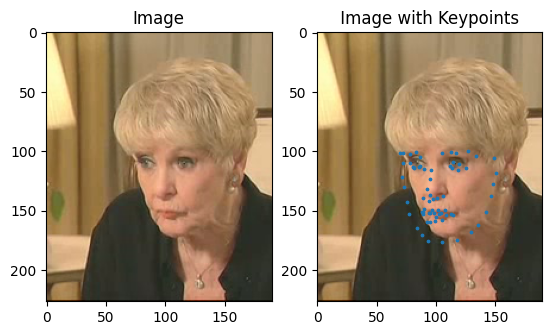

In [48]:
index = 120
test_img, points = test_dataset[index]
Facial_key_points = model(test_img[None]).flatten().detach().cpu()
plt.subplot(121)
plt.title("Image")
img = test_dataset.load_img(index)
img = img[:,:,::-1]                                                              
plt.imshow(img)
plt.subplot(122)
plt.title(" Image with Keypoints ")
plt.imshow(img)
plt.scatter(Facial_key_points[:68]*img.shape[1], Facial_key_points[68:]*img.shape[0], s=[3])
plt.show()

In [41]:
torch.save(model, 'weights_only.pth')

In [44]:
torch.save(model.state_dict(), 'facial_keypoints_model.pth')

In [46]:
from IPython.display import FileLink
FileLink(r'facial_keypoints_model.pth')

/kaggle/working/facial_keypoints_model.pth